In [1]:
import numpy as np
import os
import argparse
from tqdm import tqdm
from matplotlib import pyplot as plt

import sys
from pathlib import Path
from scipy.signal import butter, lfilter

import json
import commentjson
import pickle
import scipy.io as sio
from pathlib import Path
import numpy as np
        

In [2]:
def parse_txt(text_lines):
    time, ch1, ch2 = [], [], []
    for i, line in enumerate(text_lines):
        if i < 6:
            continue
        line = line.split("; ")
        try:
            time.append(float(line[0]))
            ch1.append(float(line[1]))
            ch2.append(float(line[2]))
        except:
            print("End line at {} ".format(i))
            break
    return np.asarray(time), np.asarray(ch1), np.asarray(ch2)

def load_text(path):
    with open(path) as f:
        return [l.replace("\n", "") for l in f.readlines()]
    
def cyc_searching (data,window):
    temp_max =0 ;
    i=0
    ind_min= 0;
    ind_max=0;
    A = data[0:window];
    B = data[window+1:2*window+1];
    if((np.max(B)-np.max(A))>0):
        direct ="up";
    else:
        direct = "down"
    collect = []
    while(1):
        A = data[i:i+window];
        B = data[i+window+1:i+2*window+1];
        if ((np.max(B)-np.max(A)) == 0): i=i+window;
        if(direct == "up"):
            #start collect
            if((np.max(B)-np.max(A))>0):       
                i=i+window;
                if((i+2*window+1)>len(data)): return collect;
            else:            
                ind_max=i+np.argmax(A)
                direct = "down";
                
        if(direct == "down"):        
            if((np.min(A)- np.min(B))>0):
                i=i+window;
                if((i+2*window+1)>len(data)): return  collect;
            else:
                ind_min=i+np.argmin(A)
                collect.append([ind_max,ind_min])
                direct = "up"

In [3]:
#generate data
data_path = "../data/meas_scope_20210823.txt"
time, raw_data, triangle_waves = parse_txt(load_text(data_path))
root_dir = os.path.split(data_path)[0]



In [4]:
window = 5000
pzt_ind = cyc_searching(triangle_waves,window)

print("get ",len(pzt_ind)," cycles")

get  29  cycles


In [5]:
pzt_ind

[[119496, 260101],
 [400687, 541377],
 [681949, 822650],
 [963225, 1103915],
 [1244472, 1385157],
 [1525730, 1666394],
 [1807048, 1947530],
 [2088290, 2228894],
 [2369490, 2510139],
 [2650736, 2791416],
 [2931963, 3072603],
 [3213291, 3353969],
 [3494489, 3635113],
 [3775834, 3916298],
 [4056907, 4197578],
 [4338238, 4478929],
 [4619632, 4760190],
 [4900720, 5041305],
 [5182099, 5322578],
 [5463230, 5603928],
 [5744624, 5885145],
 [6025744, 6166381],
 [6307023, 6447645],
 [6588315, 6728892],
 [6869451, 7010011],
 [7150637, 7291425],
 [7431953, 7572668],
 [7713228, 7853861],
 [7994484, 8135145]]

# Load 柏安 signal-det

In [6]:
signal_det_path = "../data/det_idxs.npy"
det_peaks= np.load(signal_det_path )

# Simulator

In [7]:
def package_generator(pzt_ind, det_peaks):
    ds_gen = []
    for num in range(len(pzt_ind)):
        
        first_ind = pzt_ind[num][0]
        final_ind = pzt_ind[num][1]        
        tmp_peaks=[]
        for peak in det_peaks:
            if ((peak>first_ind) & (peak < final_ind)):
                tmp_peaks.append((peak-first_ind))
                
        ds_gen.append(tmp_peaks)
        
    return ds_gen
    
def create_peaks(ds,size):
    vs = np.zeros(size)
    i=0;
    for i in range(len(ds)):        
        vs[ds[i]] = 1        
    return vs

In [8]:
# A simulator for SSF test, like a real-time data input
ds_gen = package_generator(pzt_ind,det_peaks)

# Programming SSF

In [9]:
# at t
# ds(t) = ds_gen[t]
# ds 資料結構: (one scan)
# 
#  [ x1,x2,x3,x4.... ] 
#
# comb space 需有上下限
# in the case, I supposed 5000(up) and 1000(down)
#
#
#  state = [x, x_var, c, c_var]
#  x     = offest point(initial point)
#  x_var = variance of x
#  c     = comb space
#  c_var = variance of comb space
#

In [10]:
class SSF:
    def __init__(self):
        self.x = 1000
        self.x_var = 0xffff
        self.c = 3000
        self.c_var = 500
    def get_state(self):        
        return [self.x,self.x_var,self.c,self.c_var]
    
    def predict(self):
        ##################
        #
        # To do : how to predict the state of x and c
        #
        ######################
        return 0
        
        
    def get_measu (self,ds,debug):
        up_lim = 5000
        down_lim = 1000
        delta = 0
        c = []
        c_ave =0
        c_std =0
        for i in range(len(ds)-1):
            for j in range(len(ds)-1 -i):
                delta = ds[i+j+1] - ds[i]
                if ((delta > down_lim) & (delta <up_lim)):
                    c.append(delta)
        c_ave = round(np.average(c))
        c_std = round(np.std(c))
        
        x0 =[] 
        for peak in ds:
            x = peak
            while(x>c_ave):
                x = x - c_ave
            x0.append(x)
        x0_ave = round(np.average(x0))       
        x0_std = round(np.std(x0))
        if(debug==1): print([x0_ave, x0_std, c_ave,c_std])
        return [x0_ave, x0_std, c_ave,c_std]
    
    def update(self,measu):
        self.x = round((self.x*self.x_var+measu[0]*measu[1])/(self.x_var+measu[1]))
        self.x_var = round( 1/(1/self.x_var+1/measu[1]))
        self.c = round((self.c*self.c_var+measu[2]*measu[3])/(self.c_var+measu[3]))
        self.c_var = round(1/(1/self.c_var+1/measu[3]))
    
    def create_predict_peaks(self,size):
        vs = np.zeros(size)
        i=0;
        pt = self.x
        while(pt<size):           
            vs[pt] = 1
            i = i +1
            pt = self.x + i * self.c
        return vs

In [11]:
u = SSF()
n = 28
state_collect=[]
for i in range(n):
    
    u.predict()
    
    state = u.get_state()
    # for debug
    state_collect.append(state)
    
    measu = u.get_measu(ds_gen[i],0)    
    u.update(measu)


In [12]:
# for observation of x
def plot_state_tendency(state_collect):
    x_data= np.arange(0, len(state_collect),1)
    
    x=[]
    x_var=[]
    c=[]
    c_var=[]
    for i in range(len(state_collect)):
        x.append(state_collect[i][0])
        x_var.append(state_collect[i][1])
        c.append(state_collect[i][2])
        c_var.append(state_collect[i][3]) 
        
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(6)     
    y_data = [x,x_var,c,c_var]    
    for i in range(4):
        plt.subplot(2,2,(i+1))
        plt.plot(x_data,y_data[i])
        


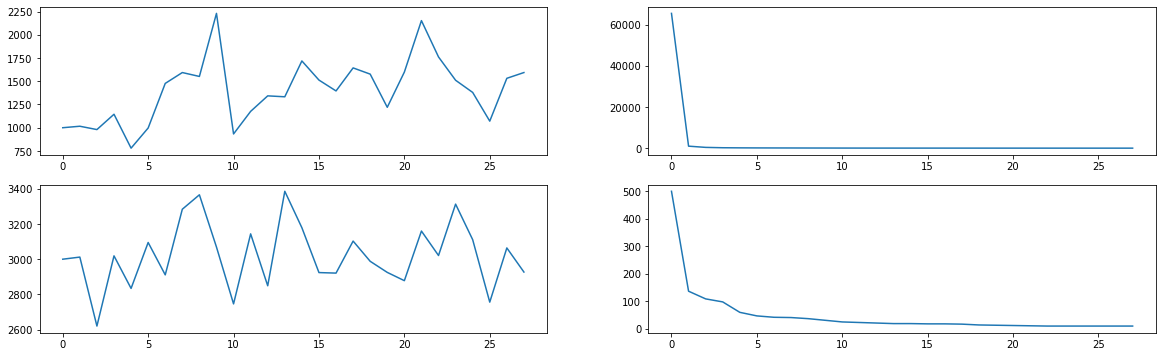

In [13]:
plot_state_tendency(state_collect)

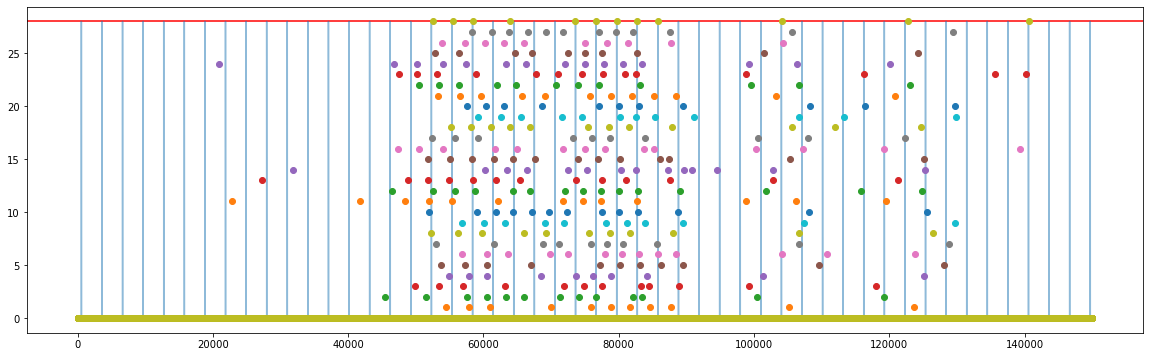

In [14]:
data_len = 150000
x= np.arange(0, data_len,1)
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(6)
plt.axhline(y=n, color='r', linestyle='-')
vs = u.create_predict_peaks(data_len)
plt.plot(x,vs*n,alpha = 0.5)
for num in range(n):
    y = create_peaks(ds_gen[num],data_len) *(num+1)
    plt.plot(x,y, 'o')   